<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.2-cp37-cp37m-linux_x86_64.whl size=2183204 sha256=ddc6bf2d95afccd8fd63cb7faed7fc9aeafc2596ed34c0a542a5a4d382611153
  Stored in directory: /root/.cache/pip/wheels/62/d6/0a/91ea5f998589bc72ca3fcf425c0e364baf8536753e1cd26ea4
Successfully built mpi4py


In [ ]:
%%writefile bifurcation.py

# Bifurcation map

import matplotlib.pyplot as plt
import numpy as np
from random import random

import numpy
from mpi4py import MPI
import time

# Initialize bifurcation parametres
n = 10
m = 20
r_beg = 0
r_end = 4
r_step = 30
x = random()  

# Initialize mpi4py variables
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print('rank',rank,'size',size)

r_values = []
if rank == 0:
  num_per_rank = r_end // size # the floor division // rounds the result down to the nearest whole number.
  for i in range(size):
    lower_bound = i * num_per_rank
    upper_bound = (i + 1) * num_per_rank
    rr = np.linspace(lower_bound, upper_bound, r_step//size)
    r_values.append(rr)
  #print("This is processor ", rank, "and I am summing numbers from", lower_bound," to ", upper_bound - 1, flush=True)
  
else:
  data = None

r_values = comm.scatter(r_values, root=0)
print("This is processor ", rank, "and I am summing for:", r_values[0], "to", r_values[-1], flush=True)

start_time = time.time()
# Start computation
res = []
for r in r_values:
    X = []
    x = random()
    for i in range(n+m):
        x = r*x*(1-x)
        if(i > n):
          X.append(x) 

    res.append(X)

print("This is processor ", rank, "data", res)
if rank == 0:
  gatheredData = comm.gather(res, root=0)
  print("-----", int((time.time() - start_time) * 1000), "-----")
  
  # Get the bifurcation map
  #plt.figure(figsize=(20, 5))
  #plt.xlabel('r')
  #plt.ylabel('X')
  #_ = plt.plot(r_values, gatheredData[0], 'b.', markersize = 0.1)

#comm.Barrier()

#stop_time = time.time()


Overwriting bifurcation.py


In [6]:
! mpirun --allow-run-as-root -np 2 python bifurcation.py

rank 0 size 2
rank 1 size 2
This is processor  0 and I am summing for: 0.0 to 2.0
This is processor  1 and I am summing for: 2.0 to 4.0
This is processor  1 data [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5333333333399479, 0.5333333333323884, 0.5333333333334683, 0.533333333333314, 0.5333333333333361, 0.533333333333333, 0.5333333333333334, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333], [0.5625000159852048, 0.562499995432798, 0.5625000013049147, 0.5624999996271672, 0.5625000001065236, 0.5624999999695647, 0.5625000000086958, 0.5624999999975155, 0.5625000000007098, 0.5624999999997973, 0.5625000000000578, 0.5624999999999835, 0.5625000000000047, 0.5624999999999986, 0.5625000000000003, 0.5624999999999999, 0.5625, 0.5625, 0.5625], [0.588344576628

In [1]:
%%writefile test.py
#try to parralell
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from random import random
#import os 
#os.environ["OMP_NUM_THREADS"] = "1"

def map_fun(r, x):
    return r*x*(1-x)

x_i = random()  #initial value of x
n = 200  #number of iterations
last = 200  #number of last values that we take into account
number_r = 100

comm = MPI.COMM_WORLD #create a communicator
rank = comm.Get_rank() #rank of executing process
size = comm.Get_size() #gives number of ranks in comm
print("my rank is ", rank)

t1 = MPI.Wtime()
r_values = np.linspace(0, 4, number_r)
r_list = np.array_split(r_values,size)[rank]
numDataPerRank = int((r_values.size)/size)


#sendbuf = np.array([])
sendbuf = []
R = []
x_n = []
#for r in r_values[rank*numDataPerRank: (rank+1)*numDataPerRank]:
for r in r_list:
    x_i = random()
    for i in range(n+last):
        x_i = map_fun(r, x_i)
        if i >= n:
            x_n.append(x_i)
            R.append(r)


sendbuf = x_n
  
t2 = MPI.Wtime()        
#comm.Gather(sendbuf, recvbuf, root=0)
recieved_x = comm.gather(sendbuf,root=0) 
recieved_r = comm.gather(R,root=0) 

if rank == 0:
    recv_x = np.hstack(recieved_x) 
    recv_r = np.hstack(recieved_r)
    #print('Rank: ',rank, ', recvbuf received: ',recvbuf, ', size', len(recvbuf))
    #fig = plt.figure()
    #plt.plot(recv_r, recv_x, ls='',marker=',')
    #plt.show()
    #fig.savefig('Bifurcation map with n = {} processes'.format(size))

Writing test.py


In [4]:
! mpirun --allow-run-as-root -n 1 python test.py

my rank is  0


In [5]:
 %timeit -o -n 1 ! mpirun --allow-run-as-root -n 1 python test.py

my rank is  0
my rank is  0
my rank is  0
my rank is  0
The slowest run took 5.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 10.5 s per loop


<TimeitResult : 1 loop, best of 5: 10.5 s per loop>

In [2]:
! mpirun --allow-run-as-root -n 2 python test.py

Traceback (most recent call last):
  File "test.py", line 2, in <module>
    from mpi4py import MPI
ModuleNotFoundError: No module named 'mpi4py'
Traceback (most recent call last):
  File "test.py", line 2, in <module>
    from mpi4py import MPI
ModuleNotFoundError: No module named 'mpi4py'
-------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code.. Per user-direction, the job has been aborted.
-------------------------------------------------------
--------------------------------------------------------------------------
mpirun detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[41924,1],0]
  Exit code:    1
--------------------------------------------------------------------------


In [5]:
timeit_arr = []
for i in range(1, 8):
#     timeit_value = %timeit -o -n 10 ! mpiexec mpirun -n {i} python bifurcation_v2.py
    timeit_value = %timeit -o -n 1 ! mpirun --allow-run-as-root -n {i} python test.py
#    timeit_arr.append(sum(timeit_value.all_runs)/len(timeit_value.all_runs))
    timeit_arr.append(sum(timeit_value.all_runs)/len(timeit_value.all_runs))
    print(i)

my rank is  0
my rank is  0
my rank is  0
my rank is  0
my rank is  0
1 loop, best of 5: 1.22 s per loop
1
my rank is  1
my rank is  0
my rank is  1
my rank is  0
my rank is  0
my rank is  1
my rank is  1
my rank is  0
my rank is  0
my rank is  1
1 loop, best of 5: 1.92 s per loop
2
my rank is  2
my rank is  0
my rank is  1
my rank is  1
my rank is  2
my rank is  0
my rank is  2
my rank is  0
my rank is  1
my rank is  0
my rank is  2
my rank is  1
my rank is  2
my rank is  0
my rank is  1
1 loop, best of 5: 2.82 s per loop
3
my rank is  0
my rank is  3
my rank is  2
my rank is  1
my rank is  2
my rank is  0
my rank is  1
my rank is  3
my rank is  2
my rank is  1
my rank is  0
my rank is  3
my rank is  0
my rank is  2
my rank is  3
my rank is  1
my rank is  2
my rank is  3
my rank is  1
my rank is  0
1 loop, best of 5: 3.63 s per loop
4
my rank is  1
my rank is  3
my rank is  4
my rank is  2
my rank is  0
my rank is  1
my rank is  0
my rank is  2
my rank is  4
my rank is  3
my rank is  

In [ ]:
timeit_value = %timeit -o -n 1 ! mpirun --allow-run-as-root -n 1 python test.py

In [6]:
timeit_value

<TimeitResult : 1 loop, best of 5: 6.14 s per loop>

In [ ]:
i

NameError: ignored

Text(0.5, 0.98, 'Speedup vs Np')

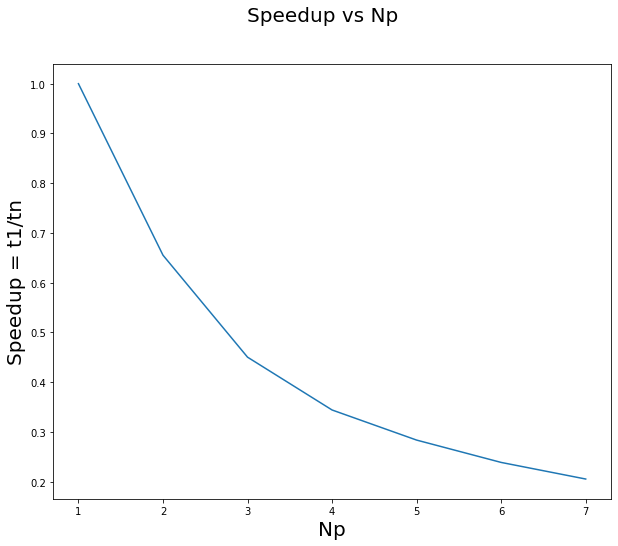

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

t1 = timeit_arr[0]
def SpeedUp(tn):
    return t1/tn
Speedup = list(map(SpeedUp, timeit_arr))
plt.figure(figsize=(10, 8))
num_of_processes = np.linspace(1, len(timeit_arr), len(timeit_arr))
plt.plot(num_of_processes, Speedup)
plt.xlabel('Np', fontsize = 20)
plt.ylabel('Speedup = t1/tn', fontsize = 20)
plt.suptitle('Speedup vs Np', fontsize = 20)


In [ ]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
   data = [(x+1)**x for x in range(size)]
   print('we will be scattering:',data)
else:
   data = None
   
data = comm.scatter(data, root=0)
data += 1
print('rank',rank,'has data:',data)

newData = comm.gather(data,root=0)

if rank == 0:
   print('master:',newData)

we will be scattering: [1]
rank 0 has data: 2
master: [2]
